## Train with rgb loss, and visualize how the loss is being calculated and the views rendered

In [ ]:
import time
from collections import OrderedDict
from pathlib import Path

import torch
from lib.structures.field_list import collect

from lib import utils, logger, config, modeling, solver, data

%load_ext autoreload
%autoreload 2

## Setup

In [2]:
config.merge_from_file('configs/front3d_train_3d.yaml')

model = modeling.PanopticReconstruction()
device = torch.device(config.MODEL.DEVICE)
model.to(device, non_blocking=True)

model.log_model_info()
model.fix_weights()

# Setup optimizer, scheduler, checkpointer
optimizer = torch.optim.Adam(model.parameters(), config.SOLVER.BASE_LR,
                                          betas=(config.SOLVER.BETA_1, config.SOLVER.BETA_2),
                                          weight_decay=config.SOLVER.WEIGHT_DECAY)
scheduler = solver.WarmupMultiStepLR(optimizer, config.SOLVER.STEPS, config.SOLVER.GAMMA,
                                                  warmup_factor=1,
                                                  warmup_iters=0,
                                                  warmup_method="linear")


-----------------------------------------
unet_output_channels 16
unet_fetures 16


In [3]:
model_dict = model.state_dict()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of Trainable Parameters: {}".format(pytorch_total_params))

output_path = Path('output')
checkpointer = utils.DetectronCheckpointer(model, optimizer, scheduler, output_path)

# Load the checkpoint
checkpoint_data = checkpointer.load()

checkpoint_arguments = {}
checkpoint_arguments["iteration"] = 0

if config.SOLVER.LOAD_SCHEDULER:
    checkpoint_arguments.update(checkpoint_data)

# TODO: move to checkpointer?
if config.MODEL.PRETRAIN2D:
    pretrain_2d = torch.load(config.MODEL.PRETRAIN2D)
    model.load_state_dict(pretrain_2d["model"])
    
# Dataloader
dataloader = data.setup_dataloader(config.DATASETS.TRAIN)

Number of Trainable Parameters: 10367060
Number of Trainable Parameters: 10367060


# Train

In [4]:
# Switch training mode
# self.model.switch_training()
print(len(dataloader))
model.switch_training()
iteration = 0
iteration_end = time.time()


for idx, (image_ids, targets) in enumerate(dataloader):
    assert targets is not None, "error during data loading"
    data_time = time.time() - iteration_end
    # Get input images
    images = collect(targets, "color")

    # Pass through model
    # try:
    losses, results = model(images, targets)
    # except Exception as e:
    #     print(e, "skipping", image_ids[0])
    #     del targets, images
    #     continue
    
    # Accumulate total loss
    total_loss: torch.Tensor = 0.0
    log_meters = OrderedDict()
    rgb_loss = 0.0
    for loss_group in losses.values():
        for loss_name, loss in loss_group.items():
            if(loss_name == "rgb"):
                # print("loss_name: {}, loss: {}".format(loss_name, loss))
                rgb_loss = loss
            if torch.is_tensor(loss) and not torch.isnan(loss) and not torch.isinf(loss):
                total_loss += loss
                log_meters[loss_name] = loss.item()

    # Loss backpropagation, optimizer & scheduler step
    optimizer.zero_grad()

    if torch.is_tensor(total_loss):
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        log_meters["total"] = total_loss.item()
    else:
        log_meters["total"] = total_loss

    # Minkowski Engine recommendation
    torch.cuda.empty_cache()
    
    # Save checkpoint
    if iteration % config.SOLVER.CHECKPOINT_PERIOD == 0:
        checkpointer.save(f"model_{iteration:07d}", **checkpoint_arguments)
    
    last_training_stage = model.set_current_training_stage(iteration)
    
    # Save additional checkpoint after hierarchy level
    if last_training_stage is not None:
        checkpointer.save(f"model_{last_training_stage}_{iteration:07d}", **checkpoint_arguments)
        logger.info(f"Finish {last_training_stage} hierarchy level")
    
    iteration += 1
    iteration_end = time.time()

    print("\riteration: {}, total_loss: {}, rgb_loss:{}".format(iteration, total_loss, rgb_loss), end="")
    if iteration%20 == 0:
        print("\riteration: {}, total_loss: {}, rgb_loss:{}".format(iteration, total_loss, rgb_loss))
        
    # if idx>4:
        # break


3000


/usr/local/lib/python3.8/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/src/app/panoptic-reconstruction/lib/modeling/projection/sparse_projection.py:195: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  padding_offsets = difference // 2
/usr/local/lib/python3.8/dist-packages/MinkowskiEngine-0.5.1-py3.8-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:512: UserWarning: __floordiv__ is deprecated, and its behavior w

iteration: 20, total_loss: 7.845524787902832, rgb_loss:0.0
iteration: 40, total_loss: 6.0132551193237305, rgb_loss:0.0
iteration: 60, total_loss: 5.569789409637451, rgb_loss:0.00
iteration: 80, total_loss: 5.296069145202637, rgb_loss:0.0
iteration: 100, total_loss: 1.9814448356628418, rgb_loss:0.0
iteration: 101, total_loss: 5.287750244140625, rgb_loss:0.0

/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:302: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  predicted_coordinates[:, 1:] = predicted_coordinates[:, 1:] // prediction.tensor_stride[0]
/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:329: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_

iteration: 120, total_loss: 69.2091064453125, rgb_loss:0.000
iteration: 140, total_loss: 65.960205078125, rgb_loss:0.0.00
iteration: 160, total_loss: 28.741291046142578, rgb_loss:0.0
iteration: 180, total_loss: 65.25492095947266, rgb_loss:0.00
iteration: 200, total_loss: 51.56214141845703, rgb_loss:0.00
iteration: 220, total_loss: 48.90152359008789, rgb_loss:0.00
iteration: 240, total_loss: 67.01423645019531, rgb_loss:0.00
iteration: 260, total_loss: 46.716121673583984, rgb_loss:0.0
iteration: 280, total_loss: 58.706565856933594, rgb_loss:0.0
iteration: 300, total_loss: 88.88964080810547, rgb_loss:0.00
iteration: 320, total_loss: 45.32438278198242, rgb_loss:0.00
iteration: 340, total_loss: 42.117774963378906, rgb_loss:0.0
iteration: 351, total_loss: 43.582786560058594, rgb_loss:0.0

/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:412: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  predicted_coordinates[:, 1:] = predicted_coordinates[:, 1:] // prediction.tensor_stride[0]
/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:509: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_

iteration: 360, total_loss: 278.6744079589844, rgb_loss:33.065101623535156
iteration: 380, total_loss: 158.65390014648438, rgb_loss:21.212308883666992
iteration: 400, total_loss: 148.99139404296875, rgb_loss:17.280139923095703
iteration: 420, total_loss: 125.3973159790039, rgb_loss:13.8833074569702157
iteration: 440, total_loss: 129.76025390625, rgb_loss:11.838182449340822952
iteration: 460, total_loss: 92.29615783691406, rgb_loss:11.4775676727294927
iteration: 480, total_loss: 92.02175903320312, rgb_loss:10.1828241348266692
iteration: 500, total_loss: 88.42268371582031, rgb_loss:9.95666122436523453
iteration: 520, total_loss: 64.04021453857422, rgb_loss:9.6572294235229581
iteration: 540, total_loss: 60.796600341796875, rgb_loss:9.7730484008789065
iteration: 560, total_loss: 55.41419219970703, rgb_loss:9.37130641937255967
iteration: 580, total_loss: 42.24504470825195, rgb_loss:9.2147941589355478
iteration: 600, total_loss: 82.12311553955078, rgb_loss:9.7936925888061523
iteration: 620, 

## Get geometry and color predictions (sparse)

In [5]:
print(results.keys())
print(results['frustum'].keys())
geometry_sparse_prediction = results['frustum']['geometry']
rgb_sparse_prediction = results['frustum']['rgb']
print("geometry_sparse shape: ", geometry_sparse_prediction.shape)
print("rgb_sparse shape: ", rgb_sparse_prediction.shape)

dict_keys(['depth', 'instance', 'projection', 'frustum'])
dict_keys(['occupancy_64', 'instance3d_64', 'semantic3d_64', 'occupancy_128', 'instance3d_128', 'semantic3d_128', 'occupancy_256', 'geometry', 'instance3d', 'instance3d_prediction', 'semantic3d', 'semantic3d_label', 'rgb'])
geometry_sparse shape:  torch.Size([101122, 1])
rgb_sparse shape:  torch.Size([101122, 3])


## Convert to dense predictions (256^3)

In [6]:
from lib.modeling.frustum.rgb_loss import RGBLoss

rgb_loss = RGBLoss()
# from .lib.modeling.frustum.rgb_loss import rgb_loss
print(results.keys())
print(results['frustum'].keys())
geometry_sparse_prediction = results['frustum']['geometry']
rgb_sparse_prediction = results['frustum']['rgb']
print("geometry_sparse shape: ", geometry_sparse_prediction.shape)
print("rgb_sparse shape: ", rgb_sparse_prediction.shape)

aux_views = targets[0].get_field("aux_views").unsqueeze(0)
cam_poses = targets[0].get_field("cam_poses").unsqueeze(0)
print("aux_views shape: ", aux_views.shape)
print("cam_poses shape: ", cam_poses.shape)


dict_keys(['depth', 'instance', 'projection', 'frustum'])
dict_keys(['occupancy_64', 'instance3d_64', 'semantic3d_64', 'occupancy_128', 'instance3d_128', 'semantic3d_128', 'occupancy_256', 'geometry', 'instance3d', 'instance3d_prediction', 'semantic3d', 'semantic3d_label', 'rgb'])
geometry_sparse shape:  torch.Size([101122, 1])
rgb_sparse shape:  torch.Size([101122, 3])
aux_views shape:  torch.Size([1, 4, 3, 240, 320])
cam_poses shape:  torch.Size([1, 4, 1, 4, 4])


## Perform one loss pass visualizing the predicted colored geometry from different views and how the loss is computed

rendered_img range: [0.0730556845664978,0.995326042175293]
mean:  tensor(0.6431, device='cuda:0', grad_fn=<MeanBackward0>)


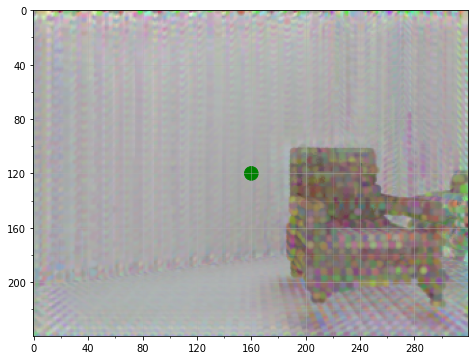

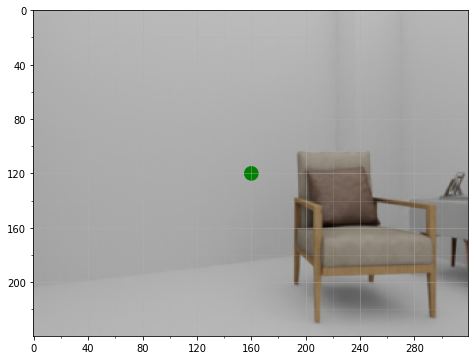

loss:  tensor(0.0119, device='cuda:0', grad_fn=<DivBackward0>)
rendered_img range: [0.0,0.9469262361526489]
mean:  tensor(0.6042, device='cuda:0', grad_fn=<MeanBackward0>)


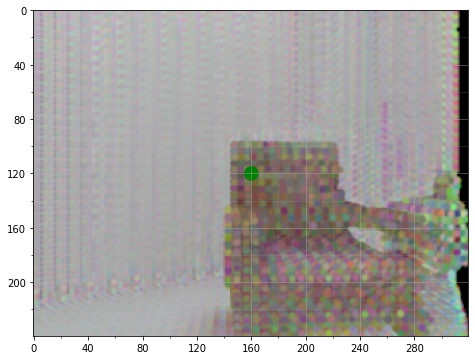

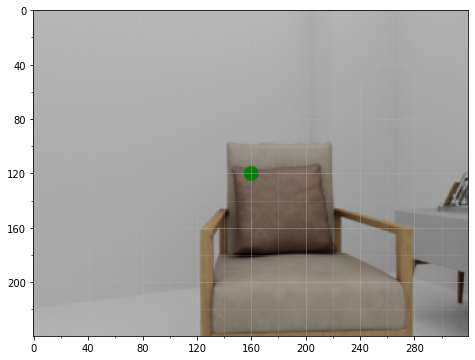

loss:  tensor(0.0152, device='cuda:0', grad_fn=<DivBackward0>)
rendered_img range: [0.0,0.8900645971298218]
mean:  tensor(0.6016, device='cuda:0', grad_fn=<MeanBackward0>)


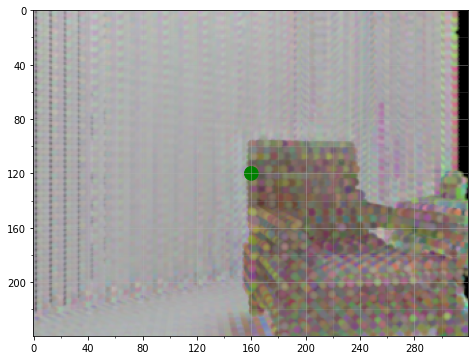

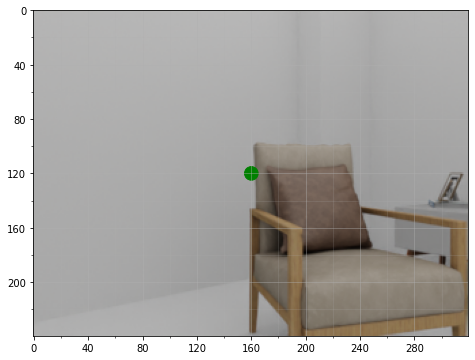

loss:  tensor(0.0139, device='cuda:0', grad_fn=<DivBackward0>)
rendered_img range: [0.0,0.8941208124160767]
mean:  tensor(0.3346, device='cuda:0', grad_fn=<MeanBackward0>)


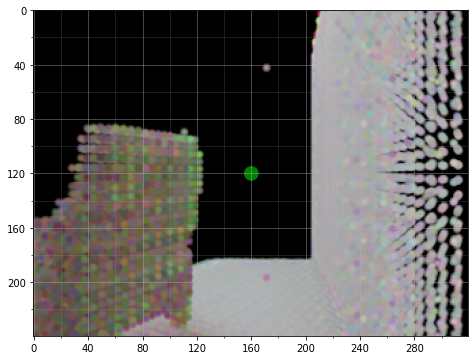

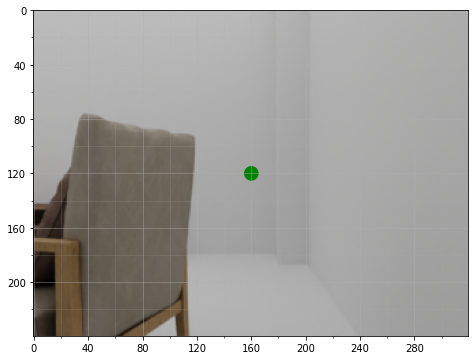

loss:  tensor(0.0234, device='cuda:0', grad_fn=<DivBackward0>)


In [7]:
loss = rgb_loss(geometry_sparse_prediction, rgb_sparse_prediction, aux_views, cam_poses.to(device), debug=True)